<a href="https://colab.research.google.com/github/SandeshRangreji/Pointer-Generator-Networks/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun 22 09:04:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
pip install tensorflow-addons

In [ ]:
pip install --upgrade tensorflow-lattice

Requirement already up-to-date: tensorflow-lattice in /usr/local/lib/python3.7/dist-packages (2.0.8)


In [ ]:
from google.colab import drive

import time
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_lattice as tfl
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

import re
import os
import shutil
import numpy as np

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzips Glove word embeddings
!unrar x "/content/drive/MyDrive/Pointer Generator Networks/glove.6B.300d.rar" -d "/content/PGN/data/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Pointer Generator Networks/glove.6B.300d.rar

Creating    /content/PGN                                              OK
Creating    /content/PGN/data                                         OK
Extracting  /content/PGN/data/glove.6B.300d.txt                            1%  2%  3%  4%  5%  6%  7%  9% 10% 11% 12% 13% 14% 15% 17% 18% 19% 20% 21% 22% 23% 24% 26% 27% 28% 29% 30% 31% 32% 34% 35% 36% 37% 38% 39% 40% 41% 43% 44% 45% 46% 47% 48% 49% 51% 52% 53% 54% 55% 56% 57% 59% 60% 61% 62% 63% 64% 65% 66% 68% 69% 70% 71% 72% 73% 74% 76% 77% 78% 79% 80% 81% 82% 83% 85% 86% 87% 88%

In [ ]:
VAL_NUM_EXAMPLES = 8192

In [ ]:
# class to handle data loading, splitting, preprocessing, tokenization
class Data:

  def __init__(self, vocab_size, oov_token):
    # dictionary for contractions
    self.tokenizer = Tokenizer(num_words = vocab_size, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', oov_token=oov_token)
    self.contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

  # function to perform contractions
  def split_contractions(self, sentence):
    # parameters:
    # sentence: article/summary (string)
    # making a list of words from the article/summary
    # return: article/summary after contractions (string)
    li_sentence = sentence.split(' ')
    # iterating through each word and replacing the contracted word if it is present in contraction dictionary
    for i in range(len(li_sentence)):
      li_sentence[i] = self.contractions.get(li_sentence[i], li_sentence[i])
    # combining the list to form a string again
    sentence = ' '.join(li_sentence)
    return sentence

  # function to handle preprocessing of articles and summaries
  def preprocess(self, sentence):
    # parameters:
    # sentence: article or summary to be processed
    # returns:
    # sentence: cleaned article/summary
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = self.split_contractions(sentence)
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = "<sos> " + sentence
    sentence = sentence.replace(" . ", " <sos> <eos> ")
    sentence = sentence[:len(sentence) - 7]
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    # removing trailing spaces
    sentence = sentence.lower().strip()
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    sentence = '<start> ' + sentence + ' <end>'
    return sentence  
  
  # splitting data into articles and summaries for training and testing
  def split_data(self, dataset):
    # parameters:
    # dataset : tfds of cnn_dailymail dataset (bytes)
    # returns:
    # train_articles, train_summaries, eval_articles, eval_summaries : lists of training and eval articles and summaries (string)
    train_articles = []
    train_summaries = []
    eval_articles = []
    eval_summaries = []
    # iterating through train dataset and storing articles and summaries seperately
    for text in tfds.as_numpy(dataset['train']):
      # decoding from bytes to string
      article = self.preprocess(text['article'].decode("utf-8"))
      summaries = self.preprocess(text['highlights'].decode("utf-8"))
      train_articles.append(article)
      train_summaries.append(summaries)

    # iterating through validation dataset and storing articles and summaries seperately
    for text in tfds.as_numpy(dataset['validation']):
      # decoding from bytes to string
      article = self.preprocess(text['article'].decode("utf-8"))
      summaries = self.preprocess(text['highlights'].decode("utf-8"))
      eval_articles.append(article)
      eval_summaries.append(summaries)
    return train_articles, train_summaries, eval_articles, eval_summaries

  # function to tokenize data
  def tokenize(self, train_articles, train_summaries, eval_articles, eval_summaries, vocab_size , embedding_dim, max_length_articles, max_length_summaries, truncating_type, padding_type, oov_token):
    # parameters:
    # train_articles, train_summaries, eval_articles, eval_summaries : lists of training and eval articles and summaries (string)
    # vocab_size: size of vocabulary
    # embedding_dim: dimensions of word embeddings
    # max_lengths_articles: number of words in the longest article
    # max_lengths_summaries: number of words in the longest summary
    # truncating_type: pre/post truncatation
    # padding_type: pro/post padding
    # oov_token: specifies what oov_token should be used
    # return:
    # train_articles, train_summaries, eval_articles, eval_summaries : lists of training and eval articles and summaries (sequences)
    # initialize tokenizer
    # fit tokenizer on training input (vocab)
    self.tokenizer.fit_on_texts(train_articles)
    # get word index from tokenizer
    word_index = self.tokenizer.word_index
    # tokenize articles for training 
    train_articles = self.tokenizer.texts_to_sequences(train_articles)
    train_articles = pad_sequences(train_articles ,maxlen=max_length_articles, padding=padding_type, truncating=truncating_type)
    # tokenize summaries for training 
    eval_articles = self.tokenizer.texts_to_sequences(eval_articles)
    eval_articles = pad_sequences(eval_articles, maxlen=max_length_articles, padding=padding_type, truncating=truncating_type)
    # tokenize articles for eval 
    train_summaries = self.tokenizer.texts_to_sequences(train_summaries)
    train_summaries = pad_sequences(train_summaries ,maxlen=max_length_summaries, padding=padding_type, truncating=truncating_type)
    # tokenize summaries for eval 
    eval_summaries = self.tokenizer.texts_to_sequences(eval_summaries)
    eval_summaries = pad_sequences(eval_summaries, maxlen=max_length_summaries, padding=padding_type, truncating=truncating_type)
    return train_articles, train_summaries, eval_articles, eval_summaries, word_index

  # function to get a dictionery which is the reverse of the word_index
  def get_reverse_word_index(self, word_index):
    # parameters:
    # word_index : { word : id }
    # returns
    # reverse_word_index : { id : word }
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    return reverse_word_index

  # get important metrics of the dataset that is needed to build a model
  def get_data_metrics(self):
    # return:
    # average length of articles, average length of summaries, length of longest article, length of longest summary
    # loading dataset
    ds = tfds.load("cnn_dailymail")
    # decoding and splitting dataset into train and eval articles and summaries
    train_articles, train_summaries, eval_articles, eval_summaries = self.split_data(ds)
    train_article_sum = 0
    max_article_len = 0
    max_summary_len = 0
    train_summaries_sum = 0
    # iterating through dataset to count total number of words
    for i in range(len(train_articles)):
      # current article and summary length (no. of words)
      article_len = len(train_articles[i].split())
      summary_len = len(train_summaries[i].split())
      # finding length of article with most number of words
      if(article_len>max_article_len):
        max_article_len = article_len
      # finding length of summary with most number of words
      if(summary_len>max_summary_len):
        max_summary_len = summary_len
      # calculating total number of words accross all articles and summary to calculate average
      train_article_sum = train_article_sum + article_len
      train_summaries_sum = train_summaries_sum + summary_len
    return train_article_sum/len(train_articles), train_summaries_sum/len(train_summaries), max_article_len, max_summary_len 

  # function to load pretrained word embeddings and prepare them for embedding layer
  def get_word_embeddings(self, word_index, vocab_size, embedding_dim):
    # parameters:
    # word_index: { word:id }
    # vocab_size: size of vocabulary
    # embedding_dim: dimension of word embeddings
    embeddings_index = {}
    # opening and reading word embeddings from file
    with open('/content/PGN/data/glove.6B.' + str(embedding_dim) + 'd.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

    # converting word embeddings to matrix (weights for embedding layer) using word_index
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None and i<=vocab_size:
            embeddings_matrix[i] = embedding_vector
    return embeddings_index, embeddings_matrix

  # function to convert list of articles and summaries to iterable, batched datasets
  def batch_datasets(self, train_articles, train_summaries, eval_articles, eval_summaries, BATCH_SIZE):
    # parameters:
    # train_articles, train_summaries, eval_articles, eval_summaries : lists of training and eval articles and summaries (sequences)
    # BATCH_SIZE: size of one batch in the dataset
    # return:
    # train_dataset, val_dataset: dataset objects for training and evaluation, batched according to BATCH_SIZE
    # making a dataset object from the train articles and summaries
    train_dataset = tf.data.Dataset.from_tensor_slices((train_articles, train_summaries))
    # batching training dataset
    train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
    # making a dataset object from the evaluation articles and summaries
    val_dataset = tf.data.Dataset.from_tensor_slices((eval_articles, eval_summaries))
    # batching evaluation dataset
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
    return train_dataset, val_dataset

  def __call__(self, num_training_examples = 2048, vocab_size = 25000, embedding_dim = 200, max_length_articles = 2880, max_length_summaries = 1344, truncating_type='post', padding_type='post', oov_token='<OOV>', BATCH_SIZE=64):
    # parameters:
    # vocab_size: size of vocabulary
    # embedding_dim: dimensions of word embeddings
    # max_lengths_articles: number of words in the longest article
    # max_lengths_summaries: number of words in the longest summary
    # truncating_type: pre/post truncatation
    # padding_type: pro/post padding
    # oov_token: specifies what oov_token should be used
    # returns:
    # train_dataset, val_dataset: dataset objects for training and evaluation, batched according to BATCH_SIZE
    # word_index : { word : id }
    # reverse_word_index : { id : word }

    # loading data in bytes from tfds
    ds=tfds.load("cnn_dailymail", shuffle_files = False)
    # splitting data into train and test sets of articles and summaries
    train_articles, train_summaries, eval_articles, eval_summaries = self.split_data(ds)
    # tokenizing data
    train_articles, train_summaries, eval_articles, eval_summaries, word_index = self.tokenize(
        train_articles[:num_training_examples], 
        train_summaries[:num_training_examples], 
        eval_articles[:VAL_NUM_EXAMPLES], 
        eval_summaries[:VAL_NUM_EXAMPLES],
        vocab_size , 
        embedding_dim, 
        max_length_articles, 
        max_length_summaries, 
        truncating_type, 
        padding_type, 
        oov_token)
    # vocab_size = len(word_index)
    # converting list of articles to train and evaluation datasets that are in batches
    train_dataset, validation_dataset = self.batch_datasets(train_articles, train_summaries, eval_articles, eval_summaries, BATCH_SIZE)
    return train_dataset, validation_dataset, word_index, self.get_reverse_word_index(word_index)

In [ ]:
vocab_size = 50000
num_examples = 32000
# num_examples = 16000
embedding_dim = 300
max_length_articles = 512
max_length_summaries = 128
truncating_type ='post'
padding_type ='post'
oov_token = "<OOV>"
BATCH_SIZE = 16
data = Data(vocab_size, oov_token)
# load, split, batch data
train_dataset, val_dataset, word_index, reverse_word_index = data(
        num_examples,
        vocab_size, 
        embedding_dim, 
        max_length_articles, 
        max_length_summaries, 
        truncating_type, 
        padding_type, 
        oov_token,
        BATCH_SIZE)

In [ ]:
# get word embeddings in the form of a matrix
embeddings_index, embeddings_matrix = data.get_word_embeddings(word_index, vocab_size, embedding_dim)

In [ ]:
embeddings_matrix.shape

(50001, 300)

In [ ]:
# sample data from dataset
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([16, 512]), TensorShape([16, 128]))

In [ ]:
# class for Encoder model
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, embeddings_matrix, hidden_dim):
    # parameters:
    # vocab_size: size of vocabulary
    # embedding_dims: dimension of word embeddings
    # enc_units: number of LSTM units in the encoder
    # batch_sz: batch size of data
    # embedding_matrix: word embeddings in the form of a matrix
    super(Encoder, self).__init__()
    # initializing model layers and some parameters of those layers
    self.batch_sz = batch_sz
    self.l1_enc_units = enc_units
    self.l2_enc_units = enc_units//2
    self.l3_enc_units = enc_units//4
    # initializing embedding layer with pretrained word embeddings
    self.embedding = tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length_articles, weights=[embeddings_matrix], trainable=False)

    ##________ LSTM layer in Encoder ------- ##
    self.lstm_layer_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.l1_enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform'))
    
    self.lstm_layer_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.l2_enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform'))
    
    self.lstm_layer_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.l3_enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform'))
    self.reduce_h = tf.keras.layers.Dense(units = hidden_dim, use_bias=True)
    self.reduce_c = tf.keras.layers.Dense(units = hidden_dim, use_bias=True)


  # build encoder model
  def call(self, x, hidden):
    x = self.embedding(x)
    output_1, forward_h1, forward_c1, backward_h1, backward_c1 = self.lstm_layer_1(x, initial_state = hidden )
    output_2, forward_h2, forward_c2, backward_h2, backward_c2 = self.lstm_layer_2(output_1)
    output_3, forward_h3, forward_c3, backward_h3, backward_c3 = self.lstm_layer_3(output_2)
    # h = tf.concat([forward_h1, backward_h1], axis=-1)
    # c = tf.concat([forward_c1, backward_c1], axis=-1)
    # h = tf.concat([forward_h2, backward_h2], axis=-1)
    # c = tf.concat([forward_c2, backward_c2], axis=-1)
    h = tf.concat([forward_h3, backward_h3], axis=-1)
    c = tf.concat([forward_c3, backward_c3], axis=-1)
    final_h = tf.keras.activations.relu(self.reduce_h(h))
    final_c = tf.keras.activations.relu(self.reduce_c(c))
    return output_3, final_h, final_c

  # initializing weights
  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.l1_enc_units)), tf.zeros((self.batch_sz, self.l1_enc_units)), tf.zeros((self.batch_sz, self.l1_enc_units)), tf.zeros((self.batch_sz, self.l1_enc_units))]

In [ ]:
## Test Encoder Stack

units = 256
# dec_units = units//2
dec_units = units

encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE, embeddings_matrix, dec_units)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder h vector shape: (batch size, units) {}'.format(sample_h.shape))
print ('Encoder c vector shape: (batch size, units) {}'.format(sample_c.shape))

Encoder output shape: (batch size, sequence length, units) (16, 512, 128)
Encoder h vector shape: (batch size, units) (16, 256)
Encoder c vector shape: (batch size, units) (16, 256)


In [ ]:
class Attention(tf.keras.layers.Layer):
  def __init__(self, hidden_dim):
    super(Attention, self).__init__()
    self.hidden_dim = hidden_dim
    self.v = tf.keras.layers.Dense(units = 1, use_bias=False)                       # v
    self.enc_proj = tf.keras.layers.Dense(units = hidden_dim*2, use_bias=False)      # W_h
    self.dec_proj = tf.keras.layers.Dense(units = hidden_dim*2, use_bias=True)        # W_s, b_attn
    self.w_c = tf.keras.layers.Dense(units = hidden_dim*2 , use_bias=False)                     # W_c

  def __call__(self, dec_input, coverage, enc_hidden):
    enc_feature = self.enc_proj(enc_hidden)         # [B x L x 2H]
    dec_feature = self.dec_proj(dec_input)          # [B x 2H]
    dec_feature = tf.expand_dims(dec_feature, 1)    # [B x 1 x 2H]
    # print(enc_feature.shape)
    # print(dec_feature.shape)
    scores = enc_feature + dec_feature              # [B x L x 2H]

    coverage = tf.expand_dims(coverage, -1)      # [B x L x 1]
    cov_feature = self.w_c(coverage)            # [B x L x 2H]
    scores = scores + cov_feature

    scores = tf.keras.activations.tanh(scores)                     # [B x L x 2H]
    scores = self.v(scores)                         # [B x L x 1]
    scores = tf.squeeze(scores, -1)                     # [B x L]
    attn_dist = tf.keras.activations.softmax(scores, axis = -1)               # [B x L]
    return attn_dist

In [ ]:
attention = Attention(dec_units)
coverage = np.random.randn(BATCH_SIZE, max_length_articles)
sample_x = tf.random.uniform((BATCH_SIZE, dec_units))
attn_dist = attention(sample_x, coverage, sample_output)
print(attn_dist.shape)

(16, 512)


In [ ]:
class PointerGenerator(tf.keras.layers.Layer):
  def __init__(self):
    super(PointerGenerator, self).__init__()
    self.w_h = tf.keras.layers.Dense(units = 1, use_bias=False) 
    self.w_s = tf.keras.layers.Dense(units = 1, use_bias=False) 
    self.w_x = tf.keras.layers.Dense(units = 1, use_bias=True) 

  def call(self, context_vec, dec_input, outputs, vocab_dist, attn_dist):
    # Eq. (8) - Compute generation probability p_gen
    context_feat = self.w_h(context_vec)                    # [B x 1]
    decoder_feat = self.w_s(outputs)                              # [B x 1]
    input_feat = self.w_x(dec_input)                          # [B x 1]
    
    gen_feat = context_feat + decoder_feat + input_feat
    p_gen = tf.keras.activations.sigmoid(gen_feat)                            # [B x 1]

    # Eq. (9) - Compute prob dist'n over extended vocabulary
    vocab_dist = p_gen * vocab_dist                         # [B x V]
    weighted_attn_dist = (1.0 - p_gen) * attn_dist          # [B x L]
    return weighted_attn_dist, vocab_dist

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    # Embedding Layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # Define the fundamental cell for decoder recurrent structure
    self.rnn_cell = tf.keras.layers.LSTMCell(self.dec_units)
    # Define the attention layer
    self.attention = Attention(self.dec_units)
    # Define the Pointer Generator 
    # self.pointerGen = PointerGenerator()
    # Fully Connected layers
    self.v = tf.keras.layers.Dense(units = dec_units, use_bias=True)   # V, b
    self.v_out = tf.keras.layers.Dense(units = vocab_size, use_bias=True)   # V', b'
    
  def initialize_hidden_state(self, batch_sz, sample_h, sample_c):
    return [sample_h, sample_c]

  def embedding(self, input):
    return self.embedding(input)

  def __call__(self, x, hidden, cov, enc_output, indices):  
    # print("In decoder")
    hidden, cell = self.rnn_cell(x, hidden)
    attn_dist = self.attention(hidden, cov, enc_output)
    # The context vector is used later to compute generation probability
    context_vec = tf.linalg.matmul(tf.expand_dims(attn_dist, 1), enc_output)   # [B x 1 x 2H]
    context_vec = tf.math.reduce_sum(context_vec, axis = 1)                    # [B x 2H] 
    # Eq. (4)
    output = self.v(tf.concat([hidden, context_vec], axis=-1))                # [B x 3H] -> [B x H]
    output = self.v_out(output)                                                # [B x V]
    vocab_dist = tf.keras.activations.softmax(output, axis=-1)                 # [B x V]
    return vocab_dist, attn_dist, context_vec, output, cell[0], cell[1]

In [ ]:
# Test decoder stack
decoder = Decoder(vocab_size, embedding_dim, dec_units, BATCH_SIZE)
sample_x = tf.random.uniform((BATCH_SIZE, embedding_dim))
hidden = decoder.initialize_hidden_state(BATCH_SIZE, sample_h, sample_c)
cov_sample = np.zeros((BATCH_SIZE, max_length_articles))
# sample_x = decoder.embedding(sample_x)
vocab_dist, attn_dist, context_vec, sample_decoder_outputs, dec_h, dec_c = decoder(sample_x, hidden, cov_sample, sample_output, example_input_batch)

# pointerGen = PointerGenerator()
print("Vocab Distribution Shape: ", vocab_dist.shape)
print("Decoder Outputs Shape: ", sample_decoder_outputs.shape)
# print("LSTM Outputs Shape: ", sample_lstm_out.shape)
print("Decoder hidden state Shape: ", dec_h.shape)
print("Decoder cell state Shape: ", dec_c.shape)
print("Attention Distribution Shape: ", attn_dist.shape)
print("Context Vector Shape: ", context_vec.shape)

Vocab Distribution Shape:  (16, 50000)
Decoder Outputs Shape:  (16, 50000)
Decoder hidden state Shape:  (16, 256)
Decoder cell state Shape:  (16, 256)
Attention Distribution Shape:  (16, 512)
Context Vector Shape:  (16, 128)


In [ ]:
def scatter_add(tensor, indices, updates):
    original_tensor = tensor
    # expand index value from vocab size
    indices = tf.compat.v1.reshape(indices, shape=[-1, tf.shape(indices)[-1]])
    indices_add = tf.compat.v1.expand_dims(tf.range(0, tf.shape(indices)[0], 1)*(tf.shape(tensor)[-1]), axis=-1)
    indices += indices_add

    # resize
    tensor = tf.compat.v1.reshape(tensor, shape=[-1])
    indices = tf.compat.v1.reshape(indices, shape=[-1, 1])
    updates = tf.compat.v1.reshape(updates, shape=[-1])

    # check_
    """
    update = tensor.shape[indices.shape[-1]:]
    res = indices.shape[:-1] + update
    """
    # same Torch scatter_add_
    scatter = tf.compat.v1.tensor_scatter_nd_add(tensor, indices, updates)
    scatter = tf.compat.v1.reshape(scatter, shape=[tf.shape(original_tensor)[0], tf.shape(original_tensor)[1], -1])
    return scatter

In [ ]:
initial_learning_rate = 0.001
# step = tf.Variable(0, trainable=False)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=(num_examples//BATCH_SIZE) * 10,
#     decay_rate=1.00,
#     staircase=True)
# wd = lambda: 1e-4 * lr_schedule(step)
# optimizer = tfa.optimizers.AdamW(learning_rate=lr_schedule, clipnorm=1.0, weight_decay=wd)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

def loss_function(real, pred):
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
  loss = cross_entropy(y_true=real, y_pred=pred)
  mask = tf.logical_not(tf.math.equal(real,0))   #output 0 for y=0 else output 1
  mask = tf.cast(mask, dtype=loss.dtype)  
  loss = mask* loss
  loss = tf.reduce_mean(loss)
  return loss

def coverage_loss(attn_dist, coverage):
  min_val = tf.math.minimum(attn_dist, coverage)   # [B x L x T]   
  loss = tf.math.reduce_sum(min_val, axis=1)            # [B x T]
  avg_loss = tf.math.reduce_sum(loss) / (BATCH_SIZE * max_length_summaries)
  return avg_loss

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
# saving weights
def save_weights_in_drive(epoch):
  if epoch!= 1:
    os.remove("/content/drive/MyDrive/Pointer Generator Networks/PGN weights/ckpt-" + str(epoch-1) + ".data-00000-of-00001")
    os.remove("/content/drive/MyDrive/Pointer Generator Networks/PGN weights/ckpt-" + str(epoch-1) + ".index")
  shutil.copy2("/content/training_checkpoints/checkpoint", '/content/drive/MyDrive/Pointer Generator Networks/PGN weights')
  shutil.copy2("/content/training_checkpoints/ckpt-" + str(epoch) + ".data-00000-of-00001", '/content/drive/MyDrive/Pointer Generator Networks/PGN weights')
  shutil.copy2("/content/training_checkpoints/ckpt-" + str(epoch) + ".index", '/content/drive/MyDrive/Pointer Generator Networks/PGN weights')
  # shutil.copy2("/content/drive/MyDrive/Pointer Generator Networks/coverage_weights.npy", '/content/drive/MyDrive/Pointer Generator Networks/PGN weights')

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden, cov):
  loss = 0
  cov_loss = 0
  cov_weight = 1.0
  # 3 lists
  final_dists = []
  attn_dists = []
  coverages = []
  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder(inp, enc_hidden)
    dec_inp = targ[ : , :-1 ]   # Ignore <end> token
    real = targ[ : , 1: ]         # ignore <start> token
    dec_h = enc_h
    dec_c = enc_c
    dec_emb = decoder.embedding(dec_inp)
    cov = tf.zeros([BATCH_SIZE, max_length_articles], tf.float32)
    for t in range(max_length_summaries-1):
      decoder_initial_state = decoder.initialize_hidden_state(BATCH_SIZE, dec_h, dec_c)
      input_t = dec_emb[:, t, :] 
      vocab_dist, attn_dist, context_vec, outputs, dec_h, dec_c = decoder(input_t, decoder_initial_state, cov, enc_output, inp)
      cov = tf.cast(cov, dtype=tf.float32)
      cov = cov + attn_dist
      final_dists.append(vocab_dist)
      attn_dists.append(attn_dist)
      coverages.append(cov)
    final_dists = tf.stack(final_dists, axis=-1)
    attn_dists = tf.stack(attn_dists, axis=-1)
    coverages = tf.stack(coverages, axis=-1)
    final_dists = tf.reshape(final_dists, [BATCH_SIZE, max_length_summaries-1, vocab_size])

    logits = final_dists
    loss = loss_function(real, logits)
    cov_loss = coverage_loss(attn_dist, cov)
    loss = loss + cov_weight * cov_loss

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables), experimental_aggregate_gradients=False)

  return loss

In [ ]:
@tf.function
def eval_step(inp, targ, enc_hidden, cov):
  loss = 0
  cov_loss = 0
  cov_weight = 1.0
  # 3 lists
  final_dists = []
  attn_dists = []
  coverages = []
  encoder.trainable = False
  decoder.trainable = False
  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder(inp, enc_hidden)
    dec_inp = targ[ : , :-1 ]   # Ignore <end> token
    real = targ[ : , 1: ]         # ignore <start> token
    dec_h = enc_h
    dec_c = enc_c
    dec_emb = decoder.embedding(dec_inp)
    cov = tf.zeros([BATCH_SIZE, max_length_articles], tf.float32)

    for t in range(max_length_summaries-1):
      decoder_initial_state = decoder.initialize_hidden_state(BATCH_SIZE, dec_h, dec_c)
      input_t = dec_emb[:, t, :] 
      vocab_dist, attn_dist, context_vec, outputs, dec_h, dec_c = decoder(input_t, decoder_initial_state, cov, enc_output, inp)
      cov = tf.cast(cov, dtype=tf.float32)
      cov = cov + attn_dist

      final_dists.append(vocab_dist)
      attn_dists.append(attn_dist)
      coverages.append(cov)
    final_dists = tf.stack(final_dists, axis=-1)
    attn_dists = tf.stack(attn_dists, axis=-1)
    coverages = tf.stack(coverages, axis=-1)
    final_dists = tf.reshape(final_dists, [BATCH_SIZE, max_length_summaries-1, vocab_size])

    logits = final_dists
    loss = loss_function(real, logits)
    cov_loss = coverage_loss(attn_dist, cov)
    loss = loss + cov_weight * cov_loss

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables), experimental_aggregate_gradients=False)

  encoder.trainable = True
  decoder.trainable = True

  return loss

In [ ]:
EPOCHS = 40
count = 1
steps_per_epoch = num_examples//BATCH_SIZE
val_steps_per_epoch = VAL_NUM_EXAMPLES//BATCH_SIZE
# steps_per_epoch = 1
if count == 1:
  cov = np.zeros((BATCH_SIZE, max_length_articles))
else:
  cov = np.load("/content/drive/MyDrive/Pointer Generator Networks/PGN weights/coverage_weights.npy")
train_losses = []
eval_losses = []
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  val_total_loss = 0
  # print(enc_hidden[0].shape, enc_hidden[1].shape)

  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden, cov)
    total_loss += batch_loss

    if batch % 400 == 0:
      print('Epoch {} Batch {} Loss {}'.format(count,
                                                   batch,
                                                   batch_loss))

  for (val_batch, (val_inp, val_targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss = eval_step(val_inp, val_targ, enc_hidden, cov)
    val_total_loss += val_batch_loss
  
  # saving (checkpoint) the model every epoch
  if (epoch + 1) % 1 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {}'.format(count,
                                      total_loss / steps_per_epoch))
  print('Epoch {} Validation Loss {}'.format(count,
                                      val_total_loss / val_steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  # print("Learning Rate: " + str(optimizer.lr.initial_learning_rate))
  train_losses.append(total_loss / steps_per_epoch)
  eval_losses.append(val_total_loss / val_steps_per_epoch)
  np.save("/content/drive/MyDrive/Pointer Generator Networks/PGN weights/coverage_weights", cov)
  save_weights_in_drive(count)
  count += 1

Epoch 1 Batch 0 Loss 5.31657075881958
Epoch 1 Batch 400 Loss 2.8432254791259766
Epoch 1 Batch 800 Loss 3.4499623775482178
Epoch 1 Batch 1200 Loss 2.9157235622406006
Epoch 1 Batch 1600 Loss 3.2047290802001953
Epoch 1 Loss 3.1850829124450684
Epoch 1 Validation Loss 3.4659030437469482
Time taken for 1 epoch 1241.9245703220367 sec

Epoch 2 Batch 0 Loss 3.5041544437408447
Epoch 2 Batch 400 Loss 2.7395734786987305
Epoch 2 Batch 800 Loss 3.3657095432281494
Epoch 2 Batch 1200 Loss 2.8484952449798584
Epoch 2 Batch 1600 Loss 3.1485507488250732
Epoch 2 Loss 3.0733017921447754
Epoch 2 Validation Loss 3.4336225986480713
Time taken for 1 epoch 1187.2241184711456 sec

Epoch 3 Batch 0 Loss 3.4371817111968994
Epoch 3 Batch 400 Loss 2.675050735473633
Epoch 3 Batch 800 Loss 3.306058406829834
Epoch 3 Batch 1200 Loss 2.795741558074951
Epoch 3 Batch 1600 Loss 3.096811294555664
Epoch 3 Loss 3.013291835784912
Epoch 3 Validation Loss 3.409167528152466
Time taken for 1 epoch 1187.1924374103546 sec

Epoch 4 Batc

In [ ]:
print(total_loss)
print(val_total_loss)

tf.Tensor(5007.549, shape=(), dtype=float32)
tf.Tensor(1709.711, shape=(), dtype=float32)


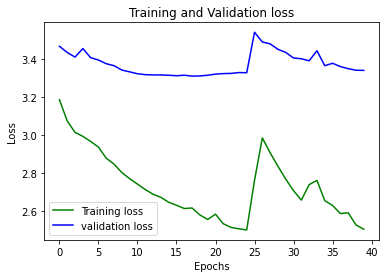

In [ ]:
epochs = range(0,EPOCHS)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, eval_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Epoch 1 Loss 1.283766269683838
def evaluate_sentence(sentence):
    sentence = data.preprocess(sentence)
    inputs = data.tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                          maxlen=max_length_articles,
                                                          padding='post')
    inputs = tf.convert_to_tensor(inputs)
    inference_batch_size = inputs.shape[0]
    encoder.trainable = False
    decoder.trainable = False
    enc_start_state = [tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units)), tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units))]
    enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

    decoded_seq = np.zeros((1,max_length_summaries))
    decoded_seq[0,0]=word_index['<start>']
    li_dec = decoded_seq
    decoded_seq_word = '<start>'

    li=[]
    len_pred_summary = max_length_summaries - 2

    dec_h = enc_h
    dec_c = enc_c
    dec_emb = decoder.embedding(decoded_seq)
    ans_arr = []
    cov = tf.zeros([1, max_length_articles], tf.float32)
    for t in range(max_length_summaries-1):
      decoder_initial_state = decoder.initialize_hidden_state(1, dec_h, dec_c)
      input_t = dec_emb[:, t, :] 
      vocab_dist, attn_dist, context_vec, outputs, dec_h, dec_c = decoder(input_t, decoder_initial_state, cov, enc_out, inp)
      cov = tf.cast(cov, dtype=tf.float32)
      cov = cov + attn_dist
      ans_arr.append(np.argmax(vocab_dist, axis = 1))
    
    encoder.trainable = True
    decoder.trainable = True
    return ans_arr

def summarize(sentence):
  result = evaluate_sentence(sentence)
  result = data.tokenizer.sequences_to_texts(result)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(" ".join(result)))

In [ ]:
test_sentence = "There are a number of job descriptions waiting for Darren Fletcher when he settles in at West Brom but the one he might not have expected is Saido Berahino’s nanny. Fletcher’s unveiling as the deadline day signing from Manchester United was almost eclipsed by the twenty-one-year-old striker, who is acquiring the habit of talking himself into trouble. Ten years Berahino’s senior, Fletcher will be expected to mentor a player who told the world this week that he wanted to play for a bigger club. Tony Pulis has advised Saido Berahino to focus on his performances at West Brom . Darren Fletcher has signed for the baggies where he will be asked to provide a role model for young players . That is off the pitch. On it, the Scotland midfielder wants to prove he is good enough to cut the mustard in the Premier League after finding starts harder and harder to come by at Old Trafford."
summarize(test_sentence)

Input: There are a number of job descriptions waiting for Darren Fletcher when he settles in at West Brom but the one he might not have expected is Saido Berahino’s nanny. Fletcher’s unveiling as the deadline day signing from Manchester United was almost eclipsed by the twenty-one-year-old striker, who is acquiring the habit of talking himself into trouble. Ten years Berahino’s senior, Fletcher will be expected to mentor a player who told the world this week that he wanted to play for a bigger club. Tony Pulis has advised Saido Berahino to focus on his performances at West Brom . Darren Fletcher has signed for the baggies where he will be asked to provide a role model for young players . That is off the pitch. On it, the Scotland midfielder wants to prove he is good enough to cut the mustard in the Premier League after finding starts harder and harder to come by at Old Trafford.
Predicted translation: prongs veendam <OOV> stepped garbine mcmillian millaa talalmusa erzurum dangerousness

In [ ]:
# saving weights
!cp "/content/training_checkpoints/checkpoint" "/content/drive/MyDrive/Pointer Generator Networks/PGN weights"
!cp "/content/training_checkpoints/ckpt-13.data-00000-of-00001" "/content/drive/MyDrive/Pointer Generator Networks/PGN weights"
!cp "/content/training_checkpoints/ckpt-13.index" "/content/drive/MyDrive/Pointer Generator Networks/PGN weights"

In [ ]:
!cp "/content/drive/MyDrive/Pointer Generator Networks/PGN weights/checkpoint" "/content/training_checkpoints/"
!cp "/content/drive/MyDrive/Pointer Generator Networks/PGN weights/ckpt-5.data-00000-of-00001" "/content/training_checkpoints/"
!cp "/content/drive/MyDrive/Pointer Generator Networks/PGN weights/ckpt-5.index" "/content/training_checkpoints/"
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))